In [1]:
import datetime
import glob
import os

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats
import tensorflow as tf
from tqdm import tqdm

import utils

In [2]:
df = pd.read_csv('merged_df_norm.csv',parse_dates=['time'])
time = df['time']
df = df.drop(['time','sf','sf_acc','tp','tp_acc'],axis=1)

In [3]:
(train_df,val_df,test_df), num_features = utils.train_test_val_split(df)

In [4]:
input_width = 72
label_width = 72
shift = label_width 

In [5]:
w1 = utils.WindowGenerator(input_width, label_width, shift,train_df, val_df, test_df, label_columns=['speed'])
w1

Total window size: 144
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label indices: [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label column name(s): ['speed']

In [6]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 144, 3)
Inputs shape: (3, 72, 3)
labels shape: (3, 72, 1)


In [7]:
w1.make_dataset(w1.train_df)

test_case = w1.train_df.copy()

In [8]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 72, 3)
Labels shape (batch, time, features): (32, 72, 1)


In [9]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [10]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', linear(w1.example[0]).shape)

Input shape: (32, 72, 3)
Output shape: (32, 72, 1)


In [11]:
val_performance = {}
performance = {}

In [12]:
# history = utils.compile_and_fit(linear, w1)

# val_performance['Linear'] = linear.evaluate(w1.val)
# performance['Linear'] = linear.evaluate(w1.test, verbose=0)

In [13]:
# performance['Linear']

In [14]:
# # plt.plot()
# ind_0 = np.random.randint(0,len(df)-1)
# width = 72

# prediction = linear.predict(df[ind_0:ind_0+width])

# plt.scatter(time[ind_0:ind_0+2*width],df[ind_0:ind_0+2*width]['speed'].values)

# plt.scatter(time[ind_0+width:ind_0+2*width],prediction)

In [15]:
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

In [16]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = utils.compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

Epoch 1/20
4542/4542 [==============================] - 44s 10ms/step - loss: 0.3382 - mean_absolute_error: 0.4259 - val_loss: 0.4508 - val_mean_absolute_error: 0.5031
Epoch 2/20
4542/4542 [==============================] - 48s 11ms/step - loss: 0.3261 - mean_absolute_error: 0.4139 - val_loss: 0.4401 - val_mean_absolute_error: 0.4948
Epoch 3/20
1295/1295 [==============================] - 7s 5ms/step - loss: 0.4410 - mean_absolute_error: 0.4950


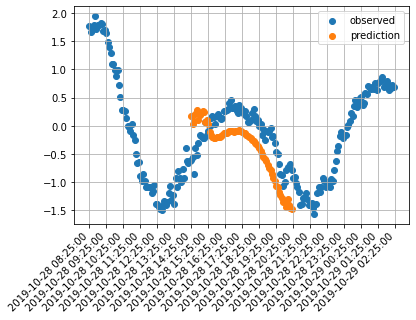

In [17]:
ind_0 = np.random.randint(0,len(df)-1)
width = 72
ticks = '1H'

prediction = dense.predict(df[ind_0:ind_0+width])

plt.scatter(time[ind_0:ind_0+3*width],df[ind_0:ind_0+3*width]['speed'].values,label='observed')

plt.scatter(time[ind_0+width:ind_0+2*width],prediction,label='prediction')

plt.grid()
start = time.loc[ind_0]
end = time.loc[ind_0+3*width]
dates = pd.date_range(start=start,end=end,freq=ticks)
plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=10)
plt.legend()

In [18]:
dense.save('no_weather')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: no_weather/assets
